### For TL;DR : Look in the TLDR version
I went through the entire tutorial, Idk what exactly happened but.

In [494]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import datetime

#### Following everything in this link literally:
https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

### 2. Load in Data and Stuff

In [495]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y%m%d')

# index_col is variable depicting time info
# date_parser converts input string into datetime
df = pd.read_csv("stockdata.csv", 
                 parse_dates=['date'],
                 index_col='date') 

    A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time. But why is it important? Most of the TS models work on the assumption that the TS is stationary. Intuitively, we can sat that if a TS has a particular behaviour over time, there is a very high probability that it will follow the same in the future.
    
    we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:

        constant mean
        constant variance
        an autocovariance that does not depend on time.

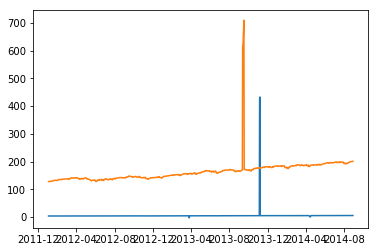

In [496]:
# First and foremost is to simple plot 
# the data and analyze visually.
plt.plot(df)
plt.show() 

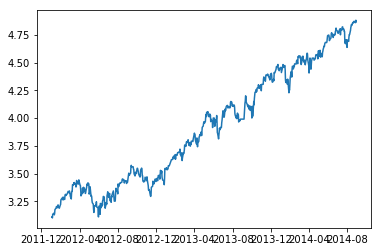

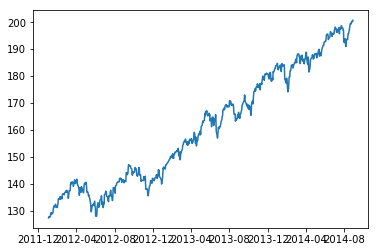

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 667 entries, 2012-01-03 to 2014-08-29
Data columns (total 2 columns):
signal             667 non-null float64
spy_close_price    664 non-null float64
dtypes: float64(2)
memory usage: 35.6 KB


In [602]:
# I am replacing outliers instead of dropping for sake of window
df = pd.read_csv("stockdata.csv", index_col='date', parse_dates=['date'])

# Replace signal outliers with last observation
sig_val = df['signal'].value_counts()
criteria = df[ (df['signal'] <= 2) | (df['signal'] >= 400) ]
df['signal'][criteria.index] = np.nan
df['signal'].fillna(method='ffill', inplace=True)

# Replace spy_close_price outliers with last observation
sig_val = df['spy_close_price'].value_counts()
criteria = df[ df['spy_close_price'] >= 500 ]
df['spy_close_price'][criteria.index] = np.nan
# df['spy_close_price'].fillna(method='ffill', inplace=True)
df['spy_close_price'].dropna(inplace=True)

plt.plot(df['signal'])
plt.show()
plt.plot(df['spy_close_price'])
plt.show() 

df.info()

### 3. How to Check Stationarity of a Time Series?

    Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.
    
    Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. 

In [498]:
from statsmodels.tsa.stattools import adfuller
from pandas.core import datetools

def test_stationarity(timeseries, window=21):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window, center=False).mean()#  window=pd.rolling_mean(timeseries, window=12)
    rolstd = timeseries.rolling(window, center=False).std() # pd.rolling_std(timeseries, window=12)
    

    #Plot rolling statistics:
    plt.figure(figsize=(15,10))
    orig = plt.plot(timeseries, color='blue',label='Original', linewidth=1)
    mean = plt.plot(rolmean, color='red', label='Rolling Mean', linewidth=1)
    std = plt.plot(rolstd, color='black', label = 'Rolling Std', linewidth=1)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

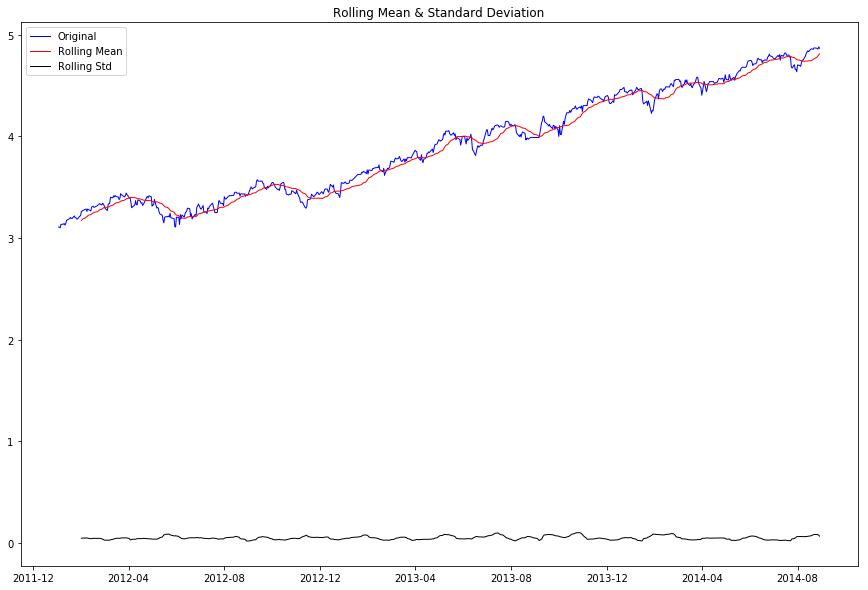

Results of Dickey-Fuller Test:
Test Statistic                  -0.195312
p-value                          0.939078
#Lags Used                       4.000000
Number of Observations Used    662.000000
Critical Value (1%)             -3.440267
Critical Value (5%)             -2.865916
Critical Value (10%)            -2.569100
dtype: float64


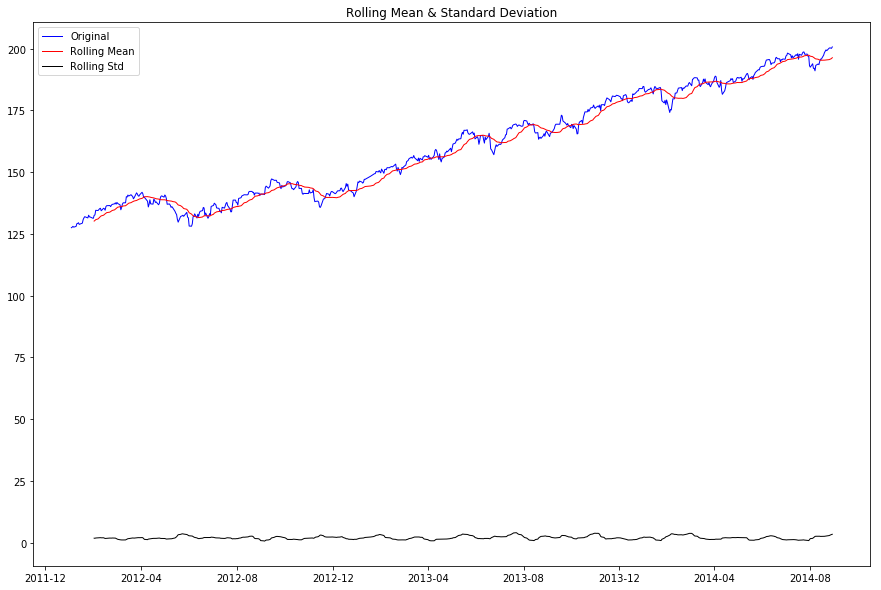

Results of Dickey-Fuller Test:
Test Statistic                  -0.334463
p-value                          0.920480
#Lags Used                       0.000000
Number of Observations Used    666.000000
Critical Value (1%)             -3.440207
Critical Value (5%)             -2.865889
Critical Value (10%)            -2.569086
dtype: float64


In [499]:
test_stationarity(df['signal'])
test_stationarity(df['spy_close_price'])

    Though the variation in standard deviation is small, mean is clearly increasing with time and this is not a stationary series. Also, the test statistic is way more than the critical values. Note that the signed values should be compared and not the absolute values.
    
    Since test statistic = -0.049772, we cannot reject the null hypothesis - From this cannot say the data is stationary. Since it < all critical values.

### 4. How to make a Time Series Stationary?

    Though stationarity assumption is taken in many TS models, almost none of practical time series are stationary. So statisticians have figured out ways to make series stationary, which we’ll discuss now. Actually, its almost impossible to make a series perfectly stationary, but we try to take it as close as possible.

    Lets understand what is making a TS non-stationary. There are 2 major reasons behind non-stationaruty of a TS:
    1. Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
    2. Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

    The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

#### Estimating & Eliminating Trend

    Transformation. Since there is a significant positive trend, we can apply transofmration which penalize higher values more than smaller values. We can do for example, a log transformation.
    
    In this simpler case, it is easy to see a forward trend in the data. But its not very intuitive in presence of noise. So we can use some techniques to estimate or model this trend and then remove it from the series. There can be many ways of doing it and some of most commonly used are:

        Aggregation – taking average for a time period like monthly/weekly averages
        Smoothing – taking rolling averages.Smoothing refers to taking rolling estimates, i.e. considering the past few instances.
        Polynomial Fitting – fit a regression model


#### Moving average
    In this approach, we take average of ‘k’ consecutive values depending on the frequency of time series. Here we can take the average over the past 1 year, i.e. last 12 values. Pandas has specific functions defined for determining rolling statistics.

In [501]:
# store the window in a variable so I don't have to kep changing it everywhere
# 10. A stock "week" is usually 5 days. The data usually has 4 or 5 days out of 5 days.
wind = 10

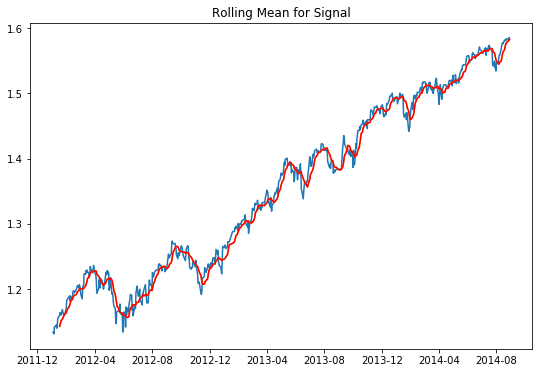

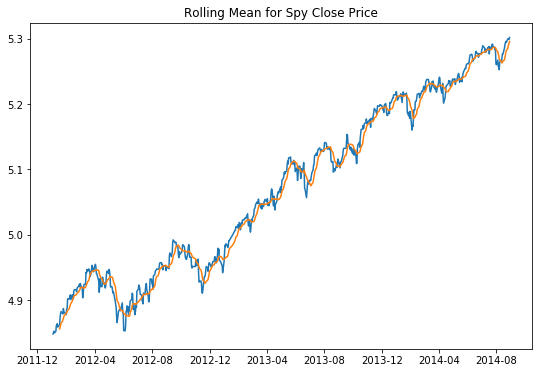

In [502]:
# Log transformation
signal_log = np.log(df['signal'])
price_log = np.log(df['spy_close_price'])

# Moving average for log transformed, with window=21 (3 weeks) 
sig_moving_avg = signal_log.rolling(wind, center=False).mean()
price_moving_avg = price_log.rolling(wind, center=False).mean()

# Plot for log transformed signal
plt.figure(figsize=(9,6))
plt.title("Rolling Mean for Signal")
plt.plot(df.index, signal_log, df.index, sig_moving_avg)
plt.plot(sig_moving_avg, color='red')
plt.show() 

# Plot for log transformed price
plt.figure(figsize=(9,6))
plt.title("Rolling Mean for Spy Close Price")
plt.plot(df.index, price_log, df.index, price_moving_avg)
plt.show() 

    The red line shows the rolling mean. Lets subtract this from the original series. Note that since we are taking average of last 12 values, rolling mean is not defined for first 11 values. This can be observed as:

In [503]:
signal_mv_avg_dif = signal_log - sig_moving_avg
price_mv_avg_dif = price_log - price_moving_avg

    Notice the first 21 being Nan. Lets drop these NaN values and check the plots to test stationarity.
    Dropping them :(

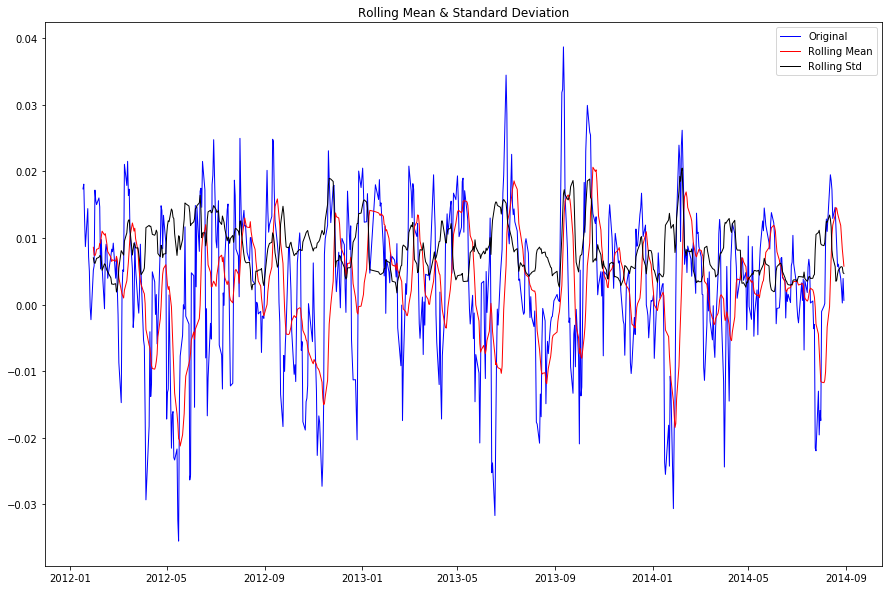

Results of Dickey-Fuller Test:
Test Statistic                -9.174857e+00
p-value                        2.334980e-15
#Lags Used                     3.000000e+00
Number of Observations Used    6.540000e+02
Critical Value (1%)           -3.440388e+00
Critical Value (5%)           -2.865969e+00
Critical Value (10%)          -2.569129e+00
dtype: float64


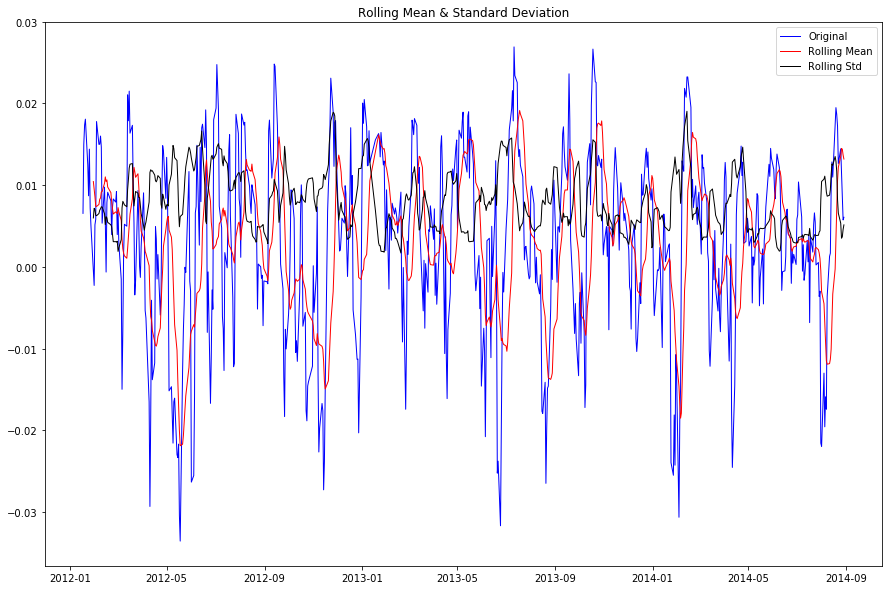

Results of Dickey-Fuller Test:
Test Statistic                -9.110788e+00
p-value                        3.404081e-15
#Lags Used                     3.000000e+00
Number of Observations Used    6.540000e+02
Critical Value (1%)           -3.440388e+00
Critical Value (5%)           -2.865969e+00
Critical Value (10%)          -2.569129e+00
dtype: float64


In [504]:
signal_mv_avg_dif.dropna(inplace=True)
price_mv_avg_dif.dropna(inplace=True)

test_stationarity(signal_mv_avg_dif, window=wind)
test_stationarity(price_mv_avg_dif, window=wind)

    The rolling values appear to be varying slightly but there is no specific trend. Also, the test statistic is ______ confidence that this is a stationary series.
    
    However, a drawback in this particular approach is that the time-period has to be strictly defined. In this case we can take yearly averages but in complex situations like forecasting a stock price, its difficult to come up with a number. So we take a ‘weighted moving average’ where more recent values are given a higher weight. There can be many technique for assigning weights. A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor. 

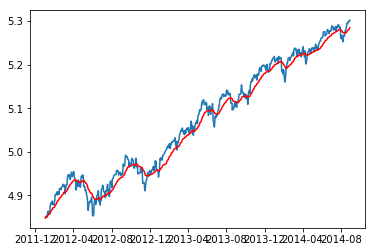

In [536]:
price_expweight_avg = price_log.ewm(halflife=wind, min_periods=0, adjust=True, ignore_na=False).mean()
plt.plot(price_log)
plt.plot(price_expweight_avg, color='red')
plt.show()

   https://www.barchart.com/stocks/quotes/$SPX/technical-analysis
   
    Note that here the parameter ‘halflife’ is used to define the amount of exponential decay. This is just an assumption here and would depend largely on the business domain. Other parameters like span and center of mass can also be used to define decay which are discussed in the link shared above. Now, let’s remove this from series and check stationarity:

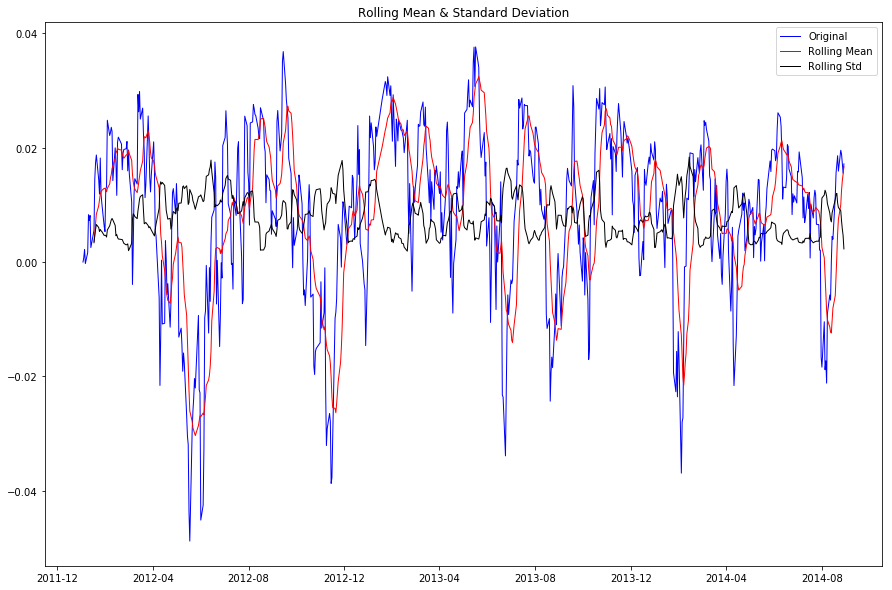

Results of Dickey-Fuller Test:
Test Statistic                -6.223849e+00
p-value                        5.145433e-08
#Lags Used                     0.000000e+00
Number of Observations Used    6.660000e+02
Critical Value (1%)           -3.440207e+00
Critical Value (5%)           -2.865889e+00
Critical Value (10%)          -2.569086e+00
dtype: float64


In [537]:
price_log_ewma_diff = price_log - price_expweight_avg
test_stationarity(price_log_ewma_diff, wind)

    This TS has even lesser variations in mean and standard deviation in magnitude. Also, the test statistic is smaller than the ~5 critical value, which is better than the previous case. Note that in this case there will be no missing values as all values from starting are given weights. So it’ll work even with no previous values.

#### Eliminating Trend and Seasonality
    The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality. Lets discuss two ways of removing trend and seasonality:

    Differencing – taking the differece with a particular time lag
    Decomposition – modeling both trend and seasonality and removing them from the model.

#### Differencing
    One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity. First order differencing can be done in Pandas as:

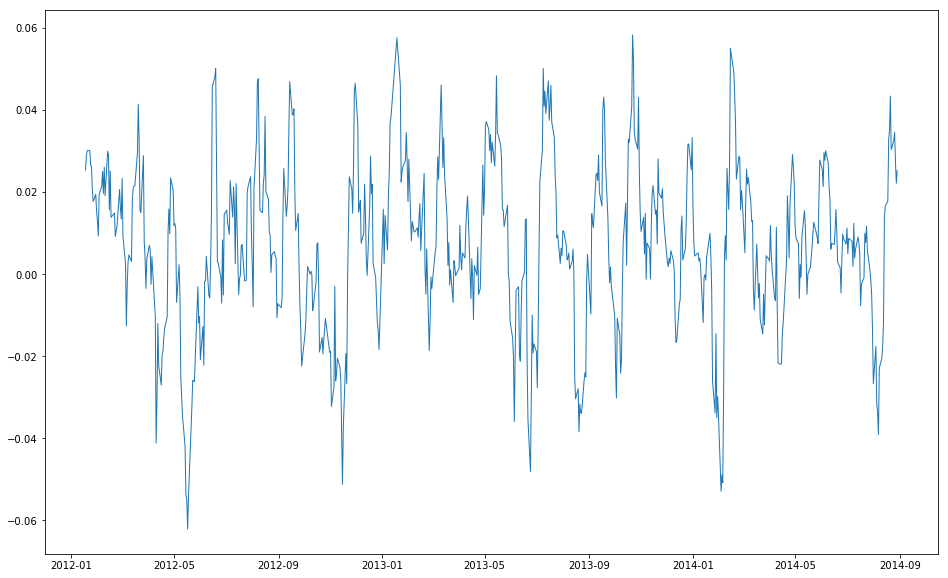

In [559]:
price_log_dif = price_log - price_log.shift(periods=wind)
plt.figure(figsize=(16,10))
plt.plot(price_log_dif, linewidth=1)
plt.show()

    This appears to have reduced trend considerably. Lets verify using our plots:

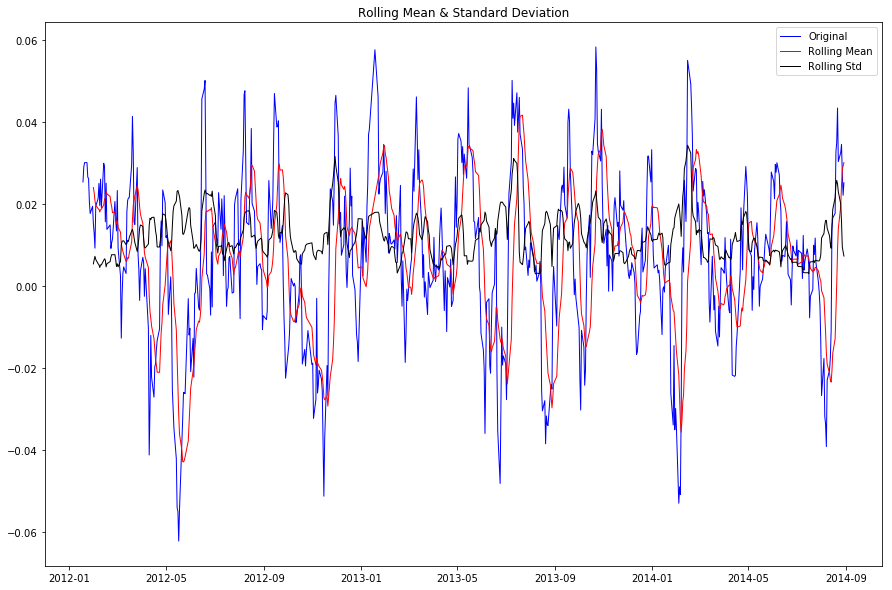

Results of Dickey-Fuller Test:
Test Statistic                  -5.023633
p-value                          0.000020
#Lags Used                      20.000000
Number of Observations Used    636.000000
Critical Value (1%)             -3.440674
Critical Value (5%)             -2.866095
Critical Value (10%)            -2.569196
dtype: float64


In [560]:
price_log_dif.dropna(inplace=True)
test_stationarity(price_log_dif, window=wind)

        
https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test
    
    From the test statistic, we can say that it is stationary.
    Since TS < All the critical values. 
    
    From wikipedia:
    In statistics and econometrics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity. It is an augmented version of the Dickey–Fuller test for a larger and more complicated set of time series models.

    The augmented Dickey–Fuller (ADF) statistic, used in the test, is a negative number. The more negative it is, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence.

#### Decomposing

    In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned.

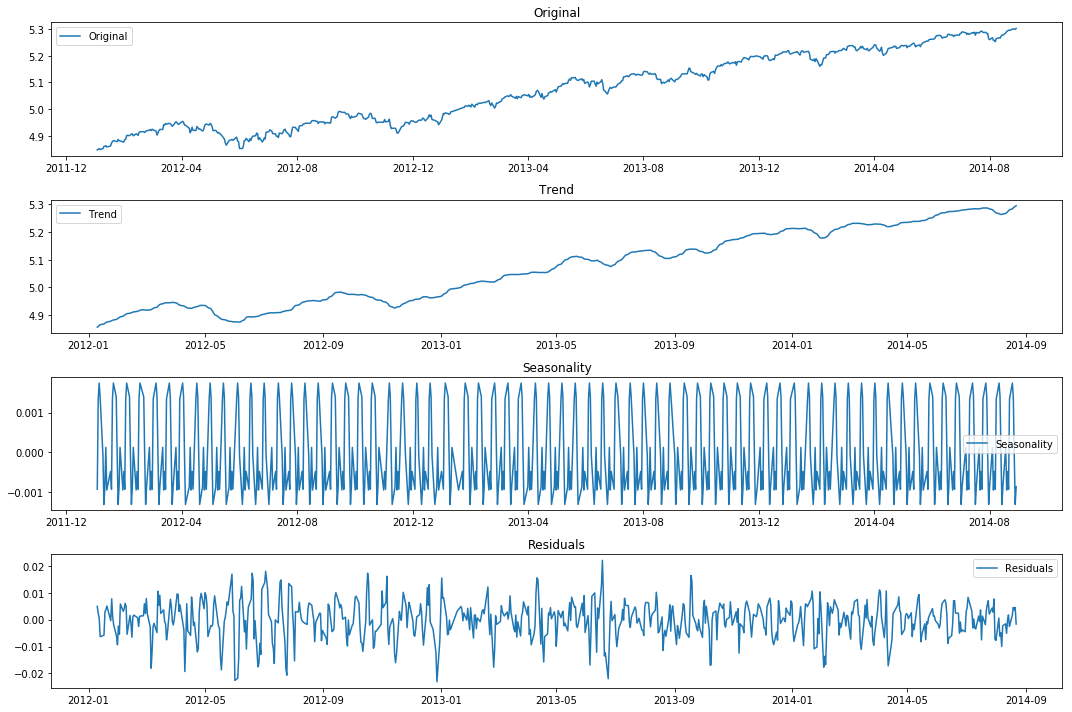

In [561]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(price_log, freq=wind)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15,10))

plt.subplot(411)
plt.title("Original")
plt.plot(price_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.title("Trend")
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.title('Seasonality')
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.title('Residuals')
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

    Here we can see that the trend, seasonality are separated out from data and we can model the residuals. Lets check stationarity of residuals:

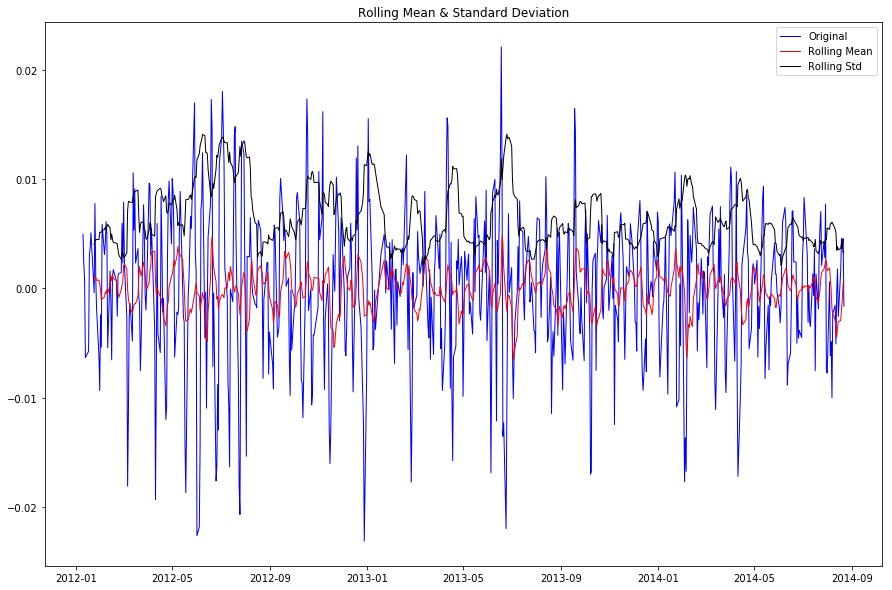

Results of Dickey-Fuller Test:
Test Statistic                -1.064815e+01
p-value                        4.736728e-19
#Lags Used                     1.300000e+01
Number of Observations Used    6.430000e+02
Critical Value (1%)           -3.440561e+00
Critical Value (5%)           -2.866045e+00
Critical Value (10%)          -2.569169e+00
dtype: float64


In [562]:
price_log_decomp = residual
price_log_decomp.dropna(inplace=True)
test_stationarity(price_log_decomp, window=wind)

### 5. Forecasting a Time Series

    We saw different techniques and all of them worked reasonably well for making the TS stationary. Lets make model on the TS after differencing as it is a very popular technique. Also, its relatively easier to add noise and seasonality back into predicted residuals in this case. Having performed the trend and seasonality estimation techniques, there can be two situations:

    - A strictly stationary series with no dependence among the values. This is the easy case wherein we can model the residuals as white noise. But this is very rare.
    - A series with significant dependence among values. In this case we need to use some statistical models like ARIMA to forecast the data.
    
    ARIMA - Auto-regressive Integrated Moving Averages. It is like a linear regression equation. The predictors dependon the parameters (p,d,q) of the ARIMA model:
        1. p - number of auto-regressive terms: Lags of dependent variable. If p=5, then predictors will be x(t-1)..x(t-5).
        2. q - number of moving average terms: Lagged forecase errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1) .. e(t-5) where e(i) is difference between the moving average at ith instand and actual value.
        3. Number of differences (d) - Number of nonseasonal differences. Here is first order difference.

    An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers. Lets discuss them first.

    Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
    
    Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.
    
    The ACF and PACF plots for the TS after differencing can be plotted as:

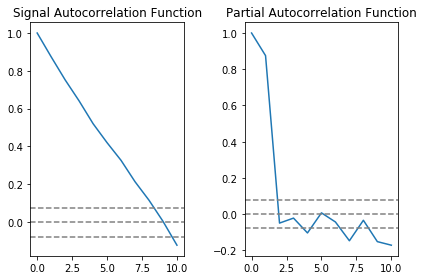

In [563]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(price_log_dif, nlags=wind)
lag_pacf = pacf(price_log_dif, nlags=wind, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(price_log_dif)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(price_log_dif)),linestyle='--',color='gray')
plt.title('Signal Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(price_log_dif)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(price_log_dif)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()


plt.show()

    In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

    p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=1.
    
    q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=1.

    Now, lets make 3 different ARIMA models considering individual as well as combined effects. I will also print the RSS for each. Please note that here RSS is for the values of residuals and not actual series.

In [564]:
from statsmodels.tsa.arima_model import ARIMA

    The p,d,q values can be specified using the order argument of ARIMA which take a tuple (p,d,q). Let model the 3 cases:

#### AR Model

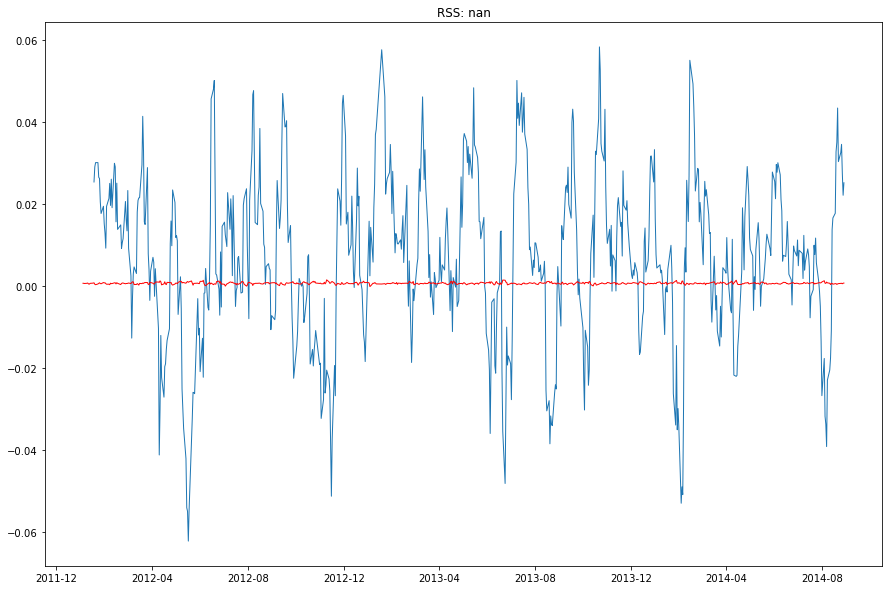

In [584]:
model = ARIMA(price_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  

plt.figure(figsize=(15,10))
plt.plot(price_log_dif, linewidth=1)
plt.plot(results_AR.fittedvalues, color='red', linewidth=1)
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-price_log_dif)**2))
plt.show()

#### MA Model

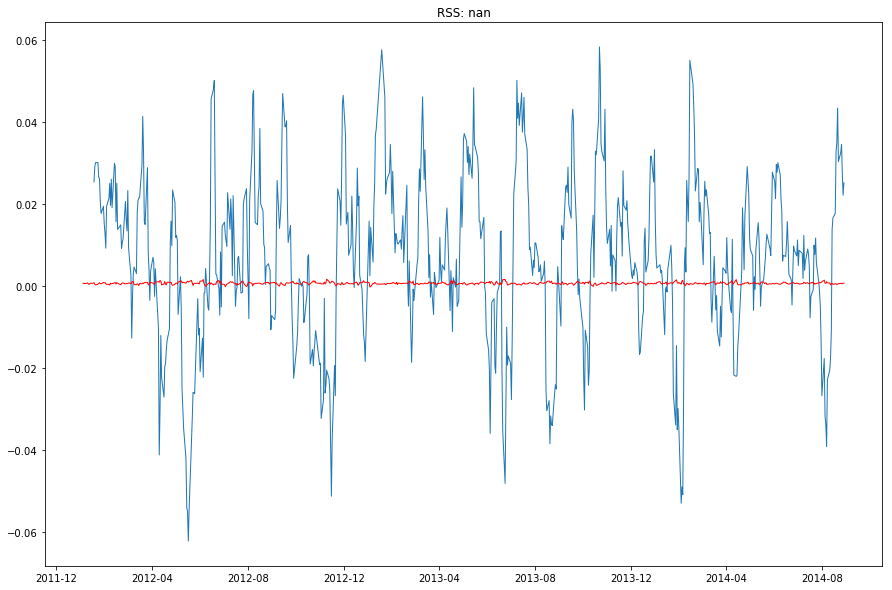

In [566]:
model = ARIMA(price_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  

plt.figure(figsize=(15,10))
plt.plot(price_log_dif, linewidth=1)
plt.plot(results_MA.fittedvalues, color='red', linewidth=1)
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-price_log_dif)**2))
plt.show()

#### Combined Model

/Applications/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Applications/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


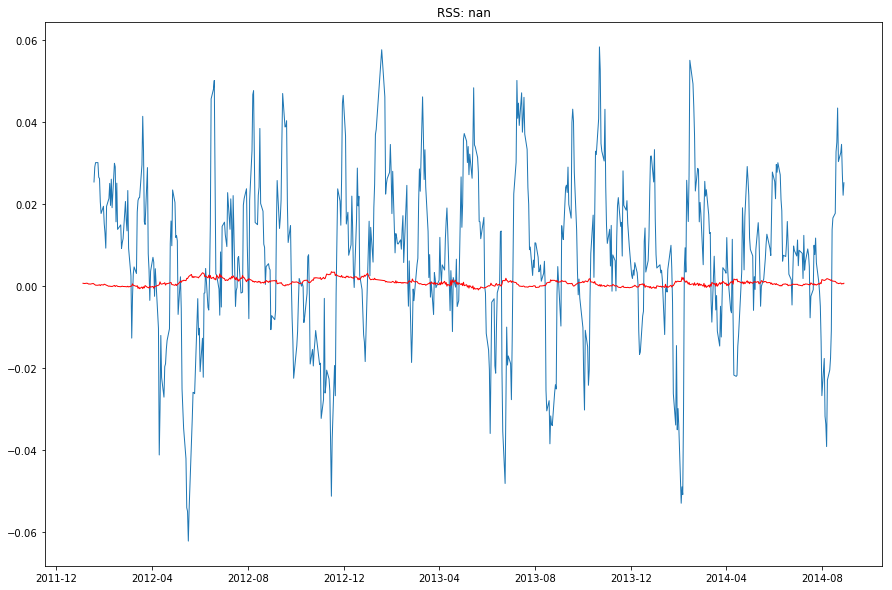

In [567]:
f

plt.show()

#results_ARIMA.summary() 

#### Taking it back to Original Scale

In [568]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

date
2012-01-04    0.000677
2012-01-05    0.000658
2012-01-06    0.000622
2012-01-09    0.000702
2012-01-10    0.000632
dtype: float64

    Notice that these start from ‘1949-02-01’ and not the first month. Why? This is because we took a lag by 1 and first element doesn’t have anything before it to subtract from. The way to convert the differencing to log scale is to add these differences consecutively to the base number. An easy way to do it is to first determine the cumulative sum at index and then add it to the base number. The cumulative sum can be found as:

In [569]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

date
2012-01-04    0.000677
2012-01-05    0.001335
2012-01-06    0.001957
2012-01-09    0.002659
2012-01-10    0.003290
dtype: float64

     Next we’ve to add them to base number. For this lets create a series with all values as base number and add the differences to it. This can be done as:



In [570]:
predictions_ARIMA_log = pd.Series(price_log.iloc[0], index=price_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head() 

date
2012-01-03    4.848077
2012-01-04    4.848755
2012-01-05    4.849412
2012-01-06    4.850034
2012-01-09    4.850736
dtype: float64

    Here the first element is base number itself and from thereon the values cumulatively added. Last step is to take the exponent and compare with the original series.

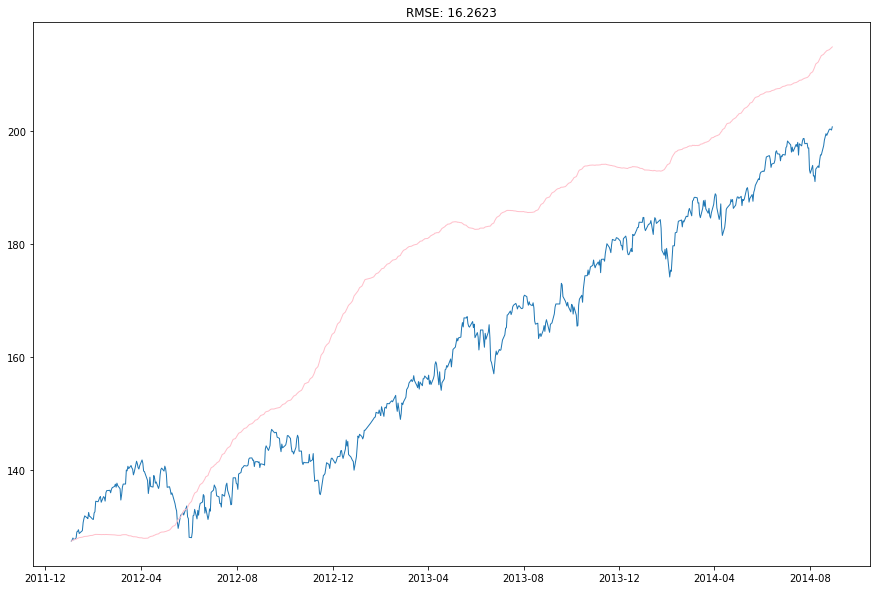

In [571]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.figure(figsize=(15,10))
plt.plot(df['spy_close_price'], linewidth=1)
plt.plot(predictions_ARIMA, linewidth=1, color='pink')
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-df['spy_close_price'])**2)/len(df['spy_close_price'])))
plt.show()

<hr>

    Lol I have no idea what happened but more or less this is a going through of that link at the top.

#### Some notes on Stationarity:

> https://www.otexts.org/fpp/8/1

> A stationary time series is one whose properties do not depend on the time at which the series is observed.1 So time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. On the other hand, a white noise series is stationary — it does not matter when you observe it, it should look much the same at any period of time.

> ome cases can be confusing — a time series with cyclic behaviour (but not trend or seasonality) is stationary. That is because the cycles are not of fixed length, so before we observe the series we cannot be sure where the peaks and troughs of the cycles will be.

> In general, a stationary time series will have no predictable patterns in the long-term. Time plots will show the series to be roughly horizontal (although some cyclic behaviour is possible) with constant variance.



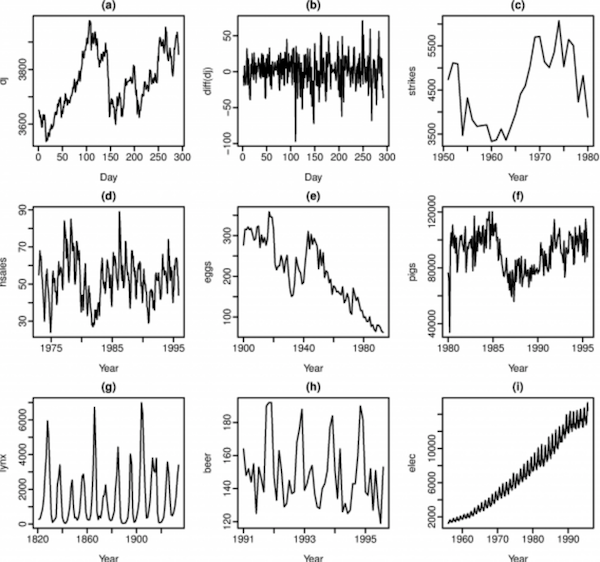

> Which of these do you think are stationary? Obvious seasonality rules out series (d), (h) and (i). Trend rules out series (a), (c), (e), (f) and (i). Increasing variance also rules out (i). That leaves only (b) and (g) as stationary series. 

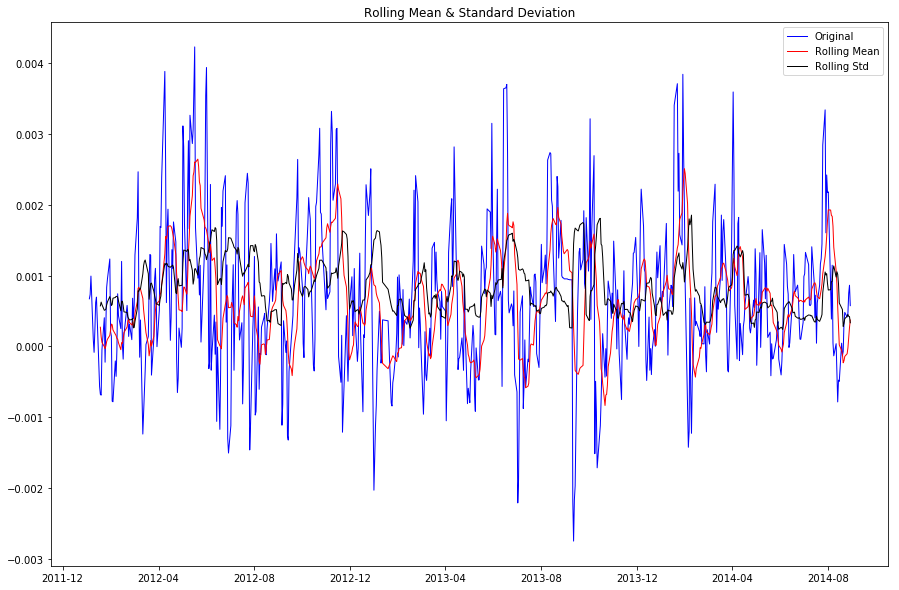

Results of Dickey-Fuller Test:
Test Statistic                -5.672961e+00
p-value                        8.835660e-07
#Lags Used                     1.900000e+01
Number of Observations Used    6.460000e+02
Critical Value (1%)           -3.440513e+00
Critical Value (5%)           -2.866024e+00
Critical Value (10%)          -2.569158e+00
dtype: float64


In [526]:
test_stationarity(results_ARIMA.fittedvalues, window=wind) 

<hr>

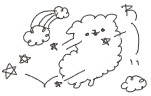

<hr>